# Introduction to Text Analysis

-----

In this notebook, we introduce text analytics, which is one of the most exciting application areas for machine learning. Text analytics forms the basis for [natural language processing][nlp], and is explicitly used for [sentiment analysis][sa], for [language identification][lc], for [spelling and grammar correction][sc], as well as for mining text data contained in forms, such as [medical informatics][mi]. Before moving into text classification and text mining, in this notebook we focus on basic text analytics such as accessing data, tokenizing a corpus, and computing token frequencies. We demonstrate these tasks by using basic Python concepts and by using functionality from within the scikit learn library. Finally, we introduce the NLTK library, and use methods within this library to perform these tasks.

---

[nlp]: https://en.wikipedia.org/wiki/Natural_language_processing
[sa]: https://en.wikipedia.org/wiki/Sentiment_analysis
[lc]: https://en.wikipedia.org/wiki/Language_identification
[sc]: http://norvig.com/spell-correct.html
[mi]: https://en.wikipedia.org/wiki/Health_informatics

## Table of Contents

[Data](#Data)

[Bag of Words](#Bag-of-Words)

[NLTK](#NLTK)

[NLTK Corpus](#NLTK-Corpus)


-----

Before proceeding with the rest of this notebook, we first include our standard notebook setup code and we define our _data_ directory.

-----

In [1]:
# Display all plots inline
% matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt

# We do this to ignore several specific warnings
import warnings
warnings.filterwarnings("ignore")

# Set global fiugure properties
import matplotlib as mpl
mpl.rcParams.update({'axes.titlesize' : 20,
                     'axes.labelsize' : 18,
                     'legend.fontsize': 16})

# Set default seaborn plotting style
sns.set(style="white")

In [2]:
# First we find our HOME directory
home_dir = !echo $HOME

# Then we create a temporary working directory to store data files in
!mkdir ~/temp_w9l1

# We construct the full path, below our   
# HOME directory to the temporary working directory location
home=home_dir[0] + '/temp_w9l1/'

mkdir: cannot create directory ‘/home/data_scientist/temp_w9l1’: File exists


-----

[[Back to TOC]](#Table-of-Contents)

## Data

To get started with text analysis, we need texts to analyze. To get started, we will analyze the [twenty newsgroup][tng] data set. We first download this data (scikit learn has built in methods for doing this, however, we have cached a copy locally on our server). The data are made available via a custom object, but we can access the data of interest by using dictionary keys. Before delving into text analysis, we first explore this data over several Code cells to understand more about the task at hand.

In case you are unaware, one primary use of the early Internet (i.e., pre-Web) was to share information among interested groups via newsgroups, or bulletin boards. Users could subscribe to these groups to send and receive postings of interest. This text classification problem uses postings to twenty newsgroups, thus the individual newsgroup is the classification target and the text in the postings are used to create the features. These postings were similar to emails, thus each posting will have a header, the article body, which might quote all or part of a previous message, and  possibly a footer (like an email signature). While we use the entire posting in these notebooks, you can have the header, quoted text, and the footer removed by scikit learn by including the remove attribute, and indicating whether these sections should be removed. This attribute can take one or all of the values: header, footer, and quotes. For example, the following attribute would be used to remove both headers and footers.

```remove =('headers', 'footers')```

---

[tng]: http://kdd.ics.uci.edu/databases/20newsgroups/20newsgroups.data.html



In [3]:
# load dataset
from sklearn.datasets import fetch_20newsgroups

text = fetch_20newsgroups(data_home=home + 'textdm')

# To learn more about these data, either browse the relevant 
# scikit learn documentation, or enter help(text) in a Code cell

# The data can be accessed via dictionary keys
print(text.keys())

Download was incomplete, downloading again.


dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR', 'description'])


In [4]:
# Display target names, i.e., the names of the 
# twenty news groups

for idx, label in enumerate(text['target_names']):
    print(f'Class {idx:2d} = {label}')

Class  0 = alt.atheism
Class  1 = comp.graphics
Class  2 = comp.os.ms-windows.misc
Class  3 = comp.sys.ibm.pc.hardware
Class  4 = comp.sys.mac.hardware
Class  5 = comp.windows.x
Class  6 = misc.forsale
Class  7 = rec.autos
Class  8 = rec.motorcycles
Class  9 = rec.sport.baseball
Class 10 = rec.sport.hockey
Class 11 = sci.crypt
Class 12 = sci.electronics
Class 13 = sci.med
Class 14 = sci.space
Class 15 = soc.religion.christian
Class 16 = talk.politics.guns
Class 17 = talk.politics.mideast
Class 18 = talk.politics.misc
Class 19 = talk.religion.misc


In [5]:
# Display single message
messageID = 251

message = text['data'][messageID]
target = text['target'][messageID]

print(f'Target Newsgroup: {text["target_names"][target]}')
print(80*'-')
print(message)

Target Newsgroup: sci.med
--------------------------------------------------------------------------------
From: geb@cs.pitt.edu (Gordon Banks)
Subject: Re: sudden numbness in arm
Reply-To: geb@cs.pitt.edu (Gordon Banks)
Organization: Univ. of Pittsburgh Computer Science
Lines: 48

In article <C5u5LG.C3G@gpu.utcc.utoronto.ca> molnar@Bisco.CAnet.CA (Tom Molnar) writes:
>I experienced a sudden numbness in my left arm this morning.  Just after
>I completed my 4th set of deep squats.  Today was my weight training
>day and I was just beginning my routine.  All of a sudden at the end of
>the 4th set my arm felt like it had gone to sleep.  It was cold, turned pale,
>and lost 60% of its strength.  The weight I used for squats wasn't that
>heavy, I was working hard but not at 100% effort.  I waited for a few 
>minutes, trying to shake the arm back to life and then continued with
>chest exercises (flyes) with lighter dumbells than I normally use.  But
>I dropped the left dumbell during the first

-----

We can analyze text messages by using basic Python commands. For example, we can find how many times a word appears in a text by using Python `string` functions. One important item to consider, however, is that, by default, Python will search for sequences of characters in a text message. Thus, if a word is also part of larger words, we will over-count the occurrences, as demonstrated in the following Code cell.

We overcome this limitation by explicitly splitting a text into tokens. By default, in Python this is done at whitespace, but this can be changed. The second Code cell demonstrates tokenizing a text string, and using a [`Counter`][pc] to accumulate the number of unique occurrences of each token. Finally, we employ regular expressions to split a text string, and use the resulting tokens to create another `Counter` that can be used to compare the results of regular expression parsing with the default string tokenization. One benefit of using regular expressions is that we can specifically indicate of what a token should be composed, in this case, we state a token is a sequence of one or more alphanumeric characters surrounded by white space. Thus the `>` token is removed.

-----
[pc]: https://docs.python.org/library/collections.html#collections.Counter

In [6]:
token = 'to'
i_token = f' {token} '

print(f'Expression Count: {message.count(token)}')
print(f'Isolated Token Count: {message.count(i_token)}')

Expression Count: 14
Isolated Token Count: 9


In [7]:
# Accumulate counts of tokens, using string functionality
import collections as cl

# Used to print out sequences
import pprint
pp = pprint.PrettyPrinter(indent=2, depth=2, width=80, compact=True)

# Tokenize and create counter
words = message.split()
wc = cl.Counter(words)

# Number of tokens to display from message
wc_display = 40

# Display results
print(f'Total number of tokens = {len(wc):d}')
print(75*'-')
print(f'Top {wc_display} tokens:')
print(75*'-')
pp.pprint(wc.most_common(wc_display))

Total number of tokens = 213
---------------------------------------------------------------------------
Top 40 tokens:
---------------------------------------------------------------------------
[ ('the', 11), ('of', 10), ('to', 9), ('and', 8), ('a', 7), ('my', 7),
  ('arm', 6), ('I', 6), ('it', 6), ('was', 4), ('is', 4), ('sudden', 3),
  ('>I', 3), ('weight', 3), ('for', 3), ('with', 3), ('geb@cs.pitt.edu', 2),
  ('(Gordon', 2), ('Banks)', 2), ('numbness', 2), ('in', 2), ('experienced', 2),
  ('left', 2), ('4th', 2), ('set', 2), ('training', 2), ('at', 2), ('>the', 2),
  ('like', 2), ('It', 2), ('>and', 2), ('that', 2), ('but', 2), ('not', 2),
  ('continued', 2), ('than', 2), ('So', 2), ('do', 2), ('>', 2), ('normal', 2)]


In [8]:
# Use regular expressions to tokenize
import re
pattern = re.compile(r'[^\w\s]')

# Tokenize and accumulate token counts
words = re.sub(pattern, ' ', message).split()
wc = cl.Counter(words)

# Display results
print(f'Total number of tokens = {len(wc):d}')
print(75*'-')
print(f'Top {wc_display} tokens:')
print(75*'-')

pp.pprint(wc.most_common(wc_display))

Total number of tokens = 207
---------------------------------------------------------------------------
Top 40 tokens:
---------------------------------------------------------------------------
[ ('the', 13), ('I', 12), ('of', 10), ('and', 10), ('my', 9), ('to', 9),
  ('arm', 7), ('a', 7), ('it', 7), ('was', 4), ('is', 4), ('geb', 3),
  ('pitt', 3), ('edu', 3), ('Gordon', 3), ('Banks', 3), ('sudden', 3),
  ('set', 3), ('weight', 3), ('for', 3), ('with', 3), ('cs', 2),
  ('numbness', 2), ('in', 2), ('experienced', 2), ('left', 2), ('4th', 2),
  ('squats', 2), ('training', 2), ('day', 2), ('at', 2), ('like', 2), ('It', 2),
  ('cold', 2), ('t', 2), ('that', 2), ('but', 2), ('not', 2), ('continued', 2),
  ('than', 2)]


-----

The previous cells tokenized a text document, but identical tokens with different case will be treated as distinct. In general, this is not a desirable result since it could undercount the occurrences of an otherwise important token. We can easily convert a text to all lowercase to prevent this, by using the string `lower` method. This is demonstrated in the following Code cell, where the total number of tokens has changed, as well as the counts of specific tokens (such as `in`).

-----

In [9]:
# We can convert message to lower-case
words = re.sub(pattern, ' ', message.lower()).split()
wc = cl.Counter(words)

# Display results
print(f'Total number of tokens = {len(wc):d}')
print(75*'-')
print(f'Top {wc_display} tokens:')
print(75*'-')
pp.pprint(wc.most_common(wc_display))

Total number of tokens = 197
---------------------------------------------------------------------------
Top 40 tokens:
---------------------------------------------------------------------------
[ ('the', 14), ('i', 12), ('to', 10), ('of', 10), ('my', 10), ('and', 10),
  ('it', 9), ('arm', 7), ('a', 7), ('was', 4), ('is', 4), ('from', 3),
  ('geb', 3), ('pitt', 3), ('edu', 3), ('gordon', 3), ('banks', 3),
  ('sudden', 3), ('in', 3), ('set', 3), ('weight', 3), ('for', 3), ('but', 3),
  ('with', 3), ('cs', 2), ('numbness', 2), ('ca', 2), ('molnar', 2),
  ('experienced', 2), ('left', 2), ('just', 2), ('4th', 2), ('squats', 2),
  ('training', 2), ('day', 2), ('at', 2), ('like', 2), ('cold', 2), ('t', 2),
  ('that', 2)]


-----

Tokenizing a text document is interesting, but traditional machine learning algorithms operate directly on numerical data. One approach to analyze a text document is to generate a numerical representation of a text document by counting the number of times a word occurs (as we did with the `Counter` collection previously. Another approach is to normalize the token counts by the total number of tokens, which creates a term (or token) frequency. We demonstrate this in the following Code cell, where we display the _top_ terms and their frequency in the message.

-----

In [10]:
print(f"{'Term':12s}: {'Frequency'}")
print(25*'-')

# Compute term counts
t_wc = sum(wc.values())

# Display counts and frequencies
for wt in wc.most_common(wc_display):
    print(f'{wt[0]:12s}: {wt[1]/t_wc:4.3f}')

Term        : Frequency
-------------------------
the         : 0.042
i           : 0.036
to          : 0.030
of          : 0.030
my          : 0.030
and         : 0.030
it          : 0.027
arm         : 0.021
a           : 0.021
was         : 0.012
is          : 0.012
from        : 0.009
geb         : 0.009
pitt        : 0.009
edu         : 0.009
gordon      : 0.009
banks       : 0.009
sudden      : 0.009
in          : 0.009
set         : 0.009
weight      : 0.009
for         : 0.009
but         : 0.009
with        : 0.009
cs          : 0.006
numbness    : 0.006
ca          : 0.006
molnar      : 0.006
experienced : 0.006
left        : 0.006
just        : 0.006
4th         : 0.006
squats      : 0.006
training    : 0.006
day         : 0.006
at          : 0.006
like        : 0.006
cold        : 0.006
t           : 0.006
that        : 0.006


-----

<font color='red' size = '5'> Student Exercise </font>

In the preceding cells, we used the twenty newsgroup data to perform some basic text analysis. Now that you have run the notebook, go back and make the following changes to see how the results change.

1. Remove the header, footer, and quoted material. How does this change the results? 
2. Change your regular expression so that tokens are sequences of two or more characters (i.e., no numbers). How does this change the results?
3. Try timing the three technique (you might want a longer text document). Which is the fastest technique? Can you explain why?

-----

[[Back to TOC]](#Table-of-Contents)

## Bag of Words

A simple question about text data mining that you might have is _How does one classify documents made up of words when machine learning algorithms work on numerical data?_ The simple answer is we need to build a numerical summary of a data set that our algorithms can manipulate. A conceptually easy approach  to implement this idea is to identify all possible words in the documents of interest and to track the number of times each words occurs in specific documents. This produces a (very) sparse matrix for our sample of documents, where the columns are the possible words (or tokens) and the rows are different documents. 

This concept, where one tokenizes documents to build these sparse matrices is more formally known as _bag of words_, because we effectively create the [bag of words][bwd] out of which are documents are constructed. In the bag of words model, each document can be mapped into a vector, where the individual elements correspond to the number of times the words (associated with the particular column) appears in the document.

With scikit learn, we can use the [`CountVectorizer`][skcv] to break our document into tokens (in this case words), which are used to construct our _bag of words_ for the given set of documents. Given this tokenizer, we first need to construct the list of tokens, which we do with the `fit` method. Second, we need to transform our documents into this sparse matrix, which we do with the `transform` method. Since both steps use the same input data, there is a convenience method to perform both operations at the same time, called `fit_transform`.

-----
[bwd]: https://en.wikipedia.org/wiki/Bag-of-words_model
[skcv]: http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [11]:
# Define our vectorizer
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(analyzer='word', lowercase=True)

-----

Given the `CountVectorizer` we can see the number of words in our _bag_ as well as the number of documents on which we train, which in this case agrees with the values we obtained when we read in the data.

-----

In [12]:
# Build a vocabulary from our data
cv.fit(text['data'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [13]:
# We can now process documents.

# We needd an iteratable to appply cv.transform()
msg = []
msg.append(message)

# Transform one message, which is easier to comprehend.
# By default, scikit learn uses sparse matrices for 
# text processing
#
# What is returned is a Document Term Matrix (dtm)
dtm = cv.transform(msg)

print(f'Number of Samples = {dtm.shape[0]}')
print(f'Number of Tokens = {dtm.shape[1]}')
print(75*'-')

# We can convert from sparse to dense to explore the 
# document-term matrix. The range was manually chosen 
# to have several non-zero elements
print(dtm.todense()[:,45141:45240])
print(75*'-')

# We can also print only nonzero DTM matrix elements
print('Tuples from Document-Term Matrix[i, j] and c (Count)')
print(75*'-')

import scipy.sparse as sp

# Find non-zero elements
i, j, c = sp.find(dtm)
dtm_list = list(zip(i, j, c))

# Display list of non-zero elements
pp.pprint(dtm_list)

Number of Samples = 1
Number of Tokens = 130107
---------------------------------------------------------------------------
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
---------------------------------------------------------------------------
Tuples from Document-Term Matrix[i, j] and c (Count)
---------------------------------------------------------------------------
[ (0, 2337, 1), (0, 11891, 1), (0, 14011, 1), (0, 14730, 2), (0, 16455, 1),
  (0, 26605, 1), (0, 27436, 1), (0, 28146, 10), (0, 28601, 1), (0, 29376, 7),
  (0, 29556, 1), (0, 29573, 1), (0, 30044, 2), (0, 30243, 1), (0, 31414, 1),
  (0, 31767, 3), (0, 31793, 1), (0, 32311, 1), (0, 32517, 1), (0, 32542, 1),
  (0, 33508, 1), (0, 33527, 1), (0, 33879, 1), (0, 34772, 1), (0, 35805, 3),
  (0, 36206, 1), (0, 36955, 1), (0, 37219, 2), (0, 37295, 1), (0, 37565, 1),
  (

-----

We can grab the words in our _bag of words_ by extracting the _vocabulary_. This allows us to see if words are present in the documents. We can also find which term occurs most frequently, least frequently, as well as the overall top terms.

-----

In [14]:
# We can explore the terms in our vocabulary
terms = cv.vocabulary_

# Look at single term
my_word = 'the'
print(f'Arbitrary Word ({my_word}): Column = {terms[my_word]}')

from operator import itemgetter
max_key = max(dtm_list, key=itemgetter(2))[1]
min_key = min(dtm_list, key=itemgetter(2))[1]

x_max = [key for key in terms.keys() if terms[key] == max_key]
x_min = [key for key in terms.keys() if terms[key] == min_key]

print(f'Max Word ({x_max[0]}): Column = {max_key}')
print(f'Min Word ({x_min[0]}): Column = {min_key}')

Arbitrary Word (the): Column = 114455
Max Word (the): Column = 114455
Min Word (100): Column = 2337


In [15]:
# Number of terms to display
top_display = 10

# Sort our document term list, and unzip
dtm_list.sort(key=itemgetter(2), reverse=True)
i, j, c = zip(*dtm_list)

# Grab out the keys and values for top terms
x_keys = [(k, v) for k, v in terms.items() 
          if terms[k] in j[:top_display]]
x_keys.sort(key=itemgetter(1), reverse=True)

# Grab the data, including counts from DTM list
x_counts = dtm_list[:top_display]
x_counts.sort(key=itemgetter(1), reverse=True)

# Now we merge the two lists so we can sort to 
# display terms in order
x_merged = []
for idx in range(len(x_keys)):
    if x_keys[idx][1] != x_counts[idx][1]:
        print('Error: column mismatch!')

    x_merged.append((x_keys[idx][0], 
                     x_keys[idx][1], 
                     x_counts[idx][2]))

x_merged.sort(key=itemgetter(2), reverse=True)

# Print results
print('Count: Term in Vocabulary')
print(40*'-')
for x in x_merged:
    print(f'{x[2]:5d}: vocabulary[{x[1]}] = {x[0]}')

Count: Term in Vocabulary
----------------------------------------
   14: vocabulary[114455] = the
   10: vocabulary[115475] = to
   10: vocabulary[89362] = of
   10: vocabulary[85354] = my
   10: vocabulary[28146] = and
    9: vocabulary[68766] = it
    7: vocabulary[29376] = arm
    4: vocabulary[123292] = was
    4: vocabulary[68532] = is
    3: vocabulary[31767] = banks


-----

<font color='red' size = '5'> Student Exercise </font>

In the preceding Code cells, we used scikit learn to parse our sample text message by using `CountVectorizer`. If you look carefully, you will notice the default results are different than our standard Python text analysis. For example, note how we do not have the single character word `a` in the list of most common items. The reason is the default tokenizer for `CountVectorizer` removes single character words (as they are assumed to be uninformative). You can change this by providing a new regular expression to the `CountVectorizer` via the `token_pattern` parameter. 

Now that you have run the notebook, go back and make the following changes to see how the results change.

1. Change the `CountVectorizer` regular expression to the string `'(?u)\\b\\w+\\b'`, how do the results change?
2. Try vectorizing a different message (i.e., transform a different message, or messages). How do the results change?
3. You can have `CountVectorizer` text processing object remove accented words by setting the `strip_accents` parameter to `True`. Does setting this parameter change the results?

-----

[[Back to TOC]](#Table-of-Contents)

## NLTK

The scikit learn library is a general purpose, Python machine learning library that does include some basic text analysis functionality. Text analysis, however is an extremely large and growing topic. As a result, we will want to explore an additional library for natural language processing. This library, known as [Natural Language ToolKit][nltk], or NLTK, enables a wide range of text analyses either on its own, or in conjunction with scikit learn. The NLTK library is extensive and includes [documentation][nltkd] covering many of the topics we have demonstrated previously.

In the rest of this notebook, we will explore how to use NLTK to perform basic text analysis, in a similar manner as demonstrated earlier via standard Python and the scikit learn library. First we import the library, and tokenize the message. We create an NLTK frequency distribution by passing a list of words to the NLTK `FreqDist` method.

-----
[nltk]: http://www.nltk.org
[nltkd]: http://www.nltk.org/book/

In [16]:
import nltk

# Tokenize a text document
words = [word.lower() for word in nltk.word_tokenize(message)]

# Count number of occurances for each token
counts = nltk.FreqDist(words)
pp.pprint(counts.most_common(top_display))

[ ('--', 78), ('>', 22), ('.', 18), ('the', 14), ('i', 12), ('of', 10),
  ('my', 10), ('and', 10), ('it', 9), ('to', 9)]


-----

We can clean up the list of tokens by using a regular expression with the `word_tokenize` method. We can reuse our previously defined regular expression `pattern = re.compile(r'[^\w\s]')` to identify tokens as one or more alphanumeric characters followed by a whitespace character. Doing this removes the punctuation tokens, as shown below.

-----

In [17]:
# Specify an RE to parse a text document
words = [word.lower() for word 
         in nltk.word_tokenize(re.sub(pattern, ' ', message))]

# Count and display token occurances
counts = nltk.FreqDist(words)
pp.pprint(counts.most_common(top_display))

[ ('the', 14), ('i', 12), ('to', 10), ('of', 10), ('my', 10), ('and', 10),
  ('it', 9), ('arm', 7), ('a', 7), ('was', 4)]


-----

One measure of the use of tokens in a document is [lexical diversity][ld], which is the fraction of unique tokens, or terms, in a document to the total tokens, or terms in a document. 

-----
[ld]: https://en.wikipedia.org/wiki/Lexical_diversity

In [18]:
# Compute and display lexical diversity
num_words = len(words)
num_tokens = len(counts)
lexdiv  =  num_words / num_tokens
print(f'Message has {num_tokens} tokens and {num_words} words', end='')
print(f' for a lexical diversity of {lexdiv:0.3f}')

Message has 197 tokens and 336 words for a lexical diversity of 1.706


-----

We can compute the number of [unique sample values][b], [number of samples outcomes][n], and the [maximum occurring token][m] with simple NLTK statistical functions. We can also iterate through and display the most commonly occurring terms and their counts.

-----
[b]: http://www.nltk.org/api/nltk.html?highlight=freqdist#nltk.probability.FreqDist.B
[n]: http://www.nltk.org/api/nltk.html?highlight=freqdist#nltk.probability.FreqDist.N
[m]: http://www.nltk.org/api/nltk.html?highlight=freqdist#nltk.probability.FreqDist.N

In [19]:
# Display number of unique tokens (or bins)
print(f'Number of unique bins(tokens) = {counts.B()}')
print(f'Number of sample outcomes = {counts.N()}')
print(f'Maximum occuring token = {counts.max()}')

print(f'\n{"Term":12s}: {"Count"}')
print(25*'-')

for token, freq in counts.most_common(top_display):
    print(f'{token:12s}:  {freq:4.3f}')

Number of unique bins(tokens) = 197
Number of sample outcomes = 336
Maximum occuring token = the

Term        : Count
-------------------------
the         :  14.000
i           :  12.000
to          :  10.000
of          :  10.000
my          :  10.000
and         :  10.000
it          :  9.000
arm         :  7.000
a           :  7.000
was         :  4.000


-----

For some machine learning applications, words that occur rarely are important. For example, in a classification process, words that are uniquely assigned to a particular message should carry considerable weight. Taken to the extreme, words that only occur once in an entire set of documents, or corpus, provide unique insight into the particular text document in which they occur. A word that only occurs once in an entire corpus is known as a [_hapax_][ha]. NLTK has a `hapaxes` method that can be used to quickly find _hapaxes_ in a corpus.

-----
[ha]: https://en.wikipedia.org/wiki/Hapax_legomenon

In [20]:
# Hapaxes
pp.pprint(counts.hapaxes()[:10])

[ 'subject', 're', 'reply', 'organization', 'univ', 'pittsburgh', 'computer',
  'science', 'lines', '48']


-----

We can also use NLTK to quickly see the most commonly used tokens. First, we can use the `tabulate` method to display the top tokens and their frequency (i.e., what we did in multiple lines of code earlier). Second, we can visually plot the counts of the top tokens by using the `plot` method. Note, we decorate the traditional plot by using , but the `plot` method will generate a simple visualization with one function call.

-----

In [21]:
counts.tabulate(top_display)

the   i  to  of  my and  it arm   a was 
 14  12  10  10  10  10   9   7   7   4 


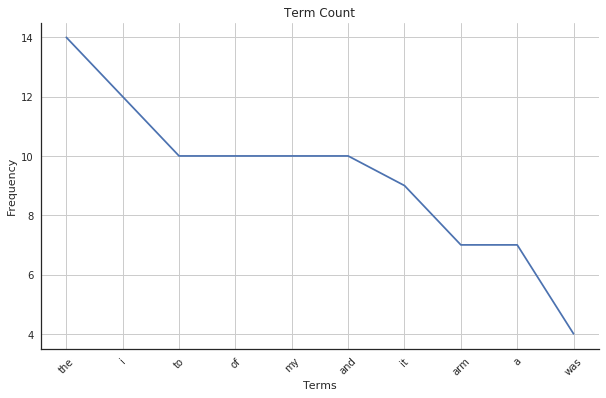

In [22]:
# Below we replicate (in a cleaner figure) the nltk 
# term-frequency plot method

fig, axs = plt.subplots(figsize=(10,6))

# Collect data from frequency distribution
terms = []
freqs = []
term_lbls = []

for term, freq in counts.most_common(top_display):
    terms.append(term)
    freqs.append(freq)
    
    # For tick labels
    term_lbls.append(str(term))

# Plot term frequencies
axs.grid(True)
axs.plot(freqs)

# Show labels
axs.set(title='Term Count', 
        xlabel='Terms', 
        ylabel='Frequency')

# Set x axis labels
axs.set_xticks(range(top_display))
axs.set_xticklabels(term_lbls, rotation=45)

# Clean up plot
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)

-----

[[Back to TOC]](#Table-of-Contents)

## NLTK Corpus

To this point, we have analyzed the twenty newsgroup data that are available from within scikit learn. The NLTK library includes a number of [data sets][nc] that can be downloaded and used directly from within NLTK. One data set that we will use repeatedly in this course will be the NLTK [movie review corpus][mrc]. These data should be available in your Docker container. If not, NLTK provides the `nltk.download()` method to download either all or one particular corpus.

In the following Code cells, we access the movie review data set, display (part) of the data set's README (or general documentation), before we begin to process the words or terms in the corpus.

-----
[nc]: http://www.nltk.org/nltk_data/
[mrc]: http://www.cs.cornell.edu/people/pabo/movie-review-data/

In [23]:
# Access the NLTK movie review data set. 
mvr = nltk.corpus.movie_reviews

In [24]:
# Print the data set README,
# remove array bounds to see entire file
print(mvr.readme()[:178])

Sentiment Polarity Dataset Version 2.0
Bo Pang and Lillian Lee

http://www.cs.cornell.edu/people/pabo/movie-review-data/

Distributed with NLTK with permission from the authors.



In [25]:
# Extract words as tokens
mvr_words = mvr.words()

# Extract summary information
counts  = nltk.FreqDist(mvr_words)
num_words = len(mvr_words)
num_tokens = len(counts)
lexdiv  =  num_words / num_tokens

# Display results
print(f'Movie Review has {num_tokens} tokens ', end='')
print(f'and {num_words} words for a ', end='')
print(f'lexical diversity of {lexdiv:4.3f}')    

Movie Review has 39768 tokens and 1583820 words for a lexical diversity of 39.826


In [26]:
# Display first fifty words
pp.pprint(mvr.words()[:50])

[ 'plot', ':', 'two', 'teen', 'couples', 'go', 'to', 'a', 'church', 'party',
  ',', 'drink', 'and', 'then', 'drive', '.', 'they', 'get', 'into', 'an',
  'accident', '.', 'one', 'of', 'the', 'guys', 'dies', ',', 'but', 'his',
  'girlfriend', 'continues', 'to', 'see', 'him', 'in', 'her', 'life', ',',
  'and', 'has', 'nightmares', '.', 'what', "'", 's', 'the', 'deal', '?',
  'watch']


-----

The data are organized into separate files for each movie review. Since these reviews have an associated sentiment: negative and positive, the reviews are categorized (via a directory structure) into `neg` or `pos` respectively. We can directly access a single review, which can be treated as a single text document. In the next few Code cells we directly access the number of files, which can be used to count the number of reviews (assuming one review per file). We also display the contents of a single file, before displaying a subset of the files in one particular category, in this case `neg`, or negative reviews.

-----

In [27]:
# Each article is in a separate file
print(f'Total Number of reviews = {len(mvr.fileids())}')

Total Number of reviews = 2000


In [28]:
a_filename = mvr.fileids()[0]
print(f'Example File: {a_filename}')

Example File: neg/cv000_29416.txt


In [29]:
# Print part of the file
pp.pprint(mvr.raw(a_filename)[:211])

('plot : two teen couples go to a church party , drink and then drive . \n'
 'they get into an accident . \n'
 'one of the guys dies , but his girlfriend continues to see him in her life , '
 'and has nightmares . \n'
 "what's the d")


In [30]:
# Display article assigned categories
pp.pprint(mvr.categories())

['neg', 'pos']


In [31]:
# Find articles that have specific category
pp.pprint(mvr.fileids('neg')[:20])

[ 'neg/cv000_29416.txt', 'neg/cv001_19502.txt', 'neg/cv002_17424.txt',
  'neg/cv003_12683.txt', 'neg/cv004_12641.txt', 'neg/cv005_29357.txt',
  'neg/cv006_17022.txt', 'neg/cv007_4992.txt', 'neg/cv008_29326.txt',
  'neg/cv009_29417.txt', 'neg/cv010_29063.txt', 'neg/cv011_13044.txt',
  'neg/cv012_29411.txt', 'neg/cv013_10494.txt', 'neg/cv014_15600.txt',
  'neg/cv015_29356.txt', 'neg/cv016_4348.txt', 'neg/cv017_23487.txt',
  'neg/cv018_21672.txt', 'neg/cv019_16117.txt']


-----

Given the contents of a file, we can process the associated text in the same manner as before. In this case, we tokenize one review into sentences as opposed to the traditional word tokens. After this, we create a list of words that are much longer than normal. As this simple example demonstrates, this can be a useful technique to search for potential problems, since in this case, none of the example shown are actual words.

-----

In [32]:
# Display sentances from an article
a_filename = 'neg/cv779_18989.txt'
for sent in mvr.sents(a_filename):
    pp.pprint(sent)

[ '9', ':', 'its', 'pathetic', 'attempt', 'at', '"', 'improving', '"', 'on',
  'a', 'shakespeare', 'classic', '.']
['8', ':', 'its', 'just', 'another', 'piece', 'of', 'teen', 'fluff', '.']
['7', ':', 'kids', 'in', 'high', 'school', 'are', 'not', 'that', 'witty', '.']
['6', ':', 'the', 'wittiness', 'is', 'not', 'witty', 'enough', '.']
['5', ':', 'the', 'comedy', 'is', 'not', 'funny', '.']
['4', ':', 'the', 'acting', 'is', 'poor', '.']
['3', ':', 'the', 'music', '.']
['2', ':', 'the', 'poster', '.']
['1', ':', 'its', 'worse', 'than', 'she', "'", 's', 'all', 'that', '!']
[ '10', '=', 'a', 'classic', '9', '=', 'borderline', 'classic', '8', '=',
  'excellent', '7', '=', 'good', '6', '=', 'better', 'than', 'average', '5',
  '=', 'average', '4', '=', 'disappointing', '3', '=', 'poor', '2', '=',
  'awful', '1', '=', 'a', 'crap', 'classic']


In [33]:
# We can process the words with normal Python
# For example, print out really long words.
long_words = [word for word in mvr_words if len(word) > 22]
long_words.sort(reverse=True)
pp.pprint(long_words)

[ 'uuuuuuggggggglllllllyyyyy', 's_funniest_home_videos_',
  '_the_last_days_of_disco_', '_i_know_what_you_did_last_summer_',
  '_fear_and_loathing_in_las_vegas_', '_breakfast_of_champions_',
  '_breakfast_of_champions_', '_a_night_at_the_roxbury_',
  '_a_night_at_the_roxbury_',
  '__________________________________________________________',
  '____________________________________________', '==========================',
  '========================', '=======================',
  '--------------------------------------------------------------',
  '--------------------------------------------------------------',
  '--------------------------------------------------------------',
  '--------------------------------------------------------------',
  '--------------------------------------------------------------',
  '--------------------------------------------------------------']


In [34]:
#Clean up - removing the temporary directory we created at the beginning of the lesson
!rm -rf $HOME/temp_w9l1

-----

<font color='red' size = '5'> Student Exercise </font>

In the preceding cells, we used NLTK to access the movie review corpus. Now that you have run the notebook, go back and make the following changes to see how the results change.

1. Tabulate the top tokens in the entire movie review corpus.
2. Plot the top tokens in the entire movie review corpus.
3. Search for words longer than eighteen characters. Did you find any real words?

-----

## Ancillary Information

The following links are to additional documentation that you might find helpful in learning this material. Reading these web-accessible documents is completely optional.

1. Introduction to [Natural Language Processing][inlp]
1. Wikipedia article on [Bag of Words][wbow] model
1. Wikipedia article on [Document Term Matrix][wdtm]
1. Gentle Introduction (in Python 2) to text analysis with Python, [part 1][nctap1] and [part 2][nctap2]
1. NY Times [article on NLP][nytnlp]
1. Wikipedia article on [Natural Language Processing][wnlp]
1. Kaggle tutorial on [Bag of Words][kbow]
1. Sections 2, 3, 5, and 6 from Chapter 1 of the free [NLTK version 3.0][nltk3] book

-----

[inlp]: https://blog.monkeylearn.com/the-definitive-guide-to-natural-language-processing/

[wnlp]: https://en.wikipedia.org/wiki/Natural_language_processing
[wbow]: https://en.wikipedia.org/wiki/Bag-of-words_model
[wdtm]: https://en.wikipedia.org/wiki/Document-term_matrix


[nytnlp]: http://www.nytimes.com/2003/10/16/technology/circuits/16mine.html?pagewanted=print
[nltk3]: http://www.nltk.org/book/ch01.html

[nctap1]: http://nealcaren.web.unc.edu/an-introduction-to-text-analysis-with-python-part-1/
[nctap2]: http://nealcaren.web.unc.edu/an-introduction-to-text-analysis-with-python-part-2/

[kbow]: https://www.kaggle.com/c/word2vec-nlp-tutorial/details/part-1-for-beginners-bag-of-words1. 

**&copy; 2017: Robert J. Brunner at the University of Illinois.**

This notebook is released under the [Creative Commons license CC BY-NC-SA 4.0][ll]. Any reproduction, adaptation, distribution, dissemination or making available of this notebook for commercial use is not allowed unless authorized in writing by the copyright holder.

[ll]: https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode